In [1]:
# 测试训练好的模型
# 1.从权重中加载模型
# 2.对test_data进行测试，把标注和预测的结果作对比
# 3.生成动画
# 4.预测一下imagesTs下的文件

In [2]:
import torch

In [3]:
import torch
from torch.utils.data import Dataset,DataLoader
import numpy as np
import matplotlib.pyplot as plt
import glob
# 数据增强相关包
import imgaug as ia
import imgaug.augmenters as iaa
from imgaug.augmentables.segmaps import SegmentationMapsOnImage

from natsort import natsorted 

In [4]:
#将画面合成为动画
from celluloid  import Camera
from IPython.display import HTML
import tqdm

In [ ]:
# 使用dataloader加载数据
num_workers = 0

test_dataset = SegmentDataset('test',None)
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=batch_size,num_workers=num_workers,shuffle=False)

In [5]:
#遍历每一层图像和mask
fig = plt.figure()
camera = Camera(fig)

# 遍历所有数据
for x,y in tqdm.tqdm(test_dataset):
    
    # 处理输入
    input = torch.tensor([x]).to('cuda:0',dtype=torch.float32)
    # 推理
    y_pred = model(input)
    
    # 获取对应的mask（筛选阈值0.5）
    mask_data = (y_pred.detach().cpu().numpy()[0][0] > 0.5)
    
    # 作比对，左侧显示标注，右侧显示实际推理
    plt.subplot(1,2,1)
    # 显示图片
    plt.imshow(x[0],cmap='bone')
    
    mask = np.ma.masked_where(y[0]==0,y[0])
    plt.imshow(mask,alpha=0.8,cmap='spring')
    plt.title('Label GD')
    plt.axis('off')
    
    
    plt.subplot(1,2,2)
    # 显示图片
    plt.imshow(x[0],cmap='bone')
    
    mask = np.ma.masked_where(mask_data==False,mask_data)
    plt.imshow(mask,alpha=0.8,cmap='spring')
    plt.title('prediction ')
    plt.axis('off')
    
    camera.snap()
    # break
animation = camera.animate()

NameError: name 'test_dataset' is not defined

<Figure size 640x480 with 0 Axes>

In [15]:
HTML(animation.to_html5_video())

In [16]:
# 测试未知图片

In [17]:
import glob
import os 
import nibabel as nib

In [18]:
test_file_list = glob.glob('data/imagesTs/la*')

In [19]:
test_file_list

['data/imagesTs\\la_001.nii.gz',
 'data/imagesTs\\la_002.nii.gz',
 'data/imagesTs\\la_006.nii.gz',
 'data/imagesTs\\la_008.nii.gz',
 'data/imagesTs\\la_012.nii.gz',
 'data/imagesTs\\la_013.nii.gz',
 'data/imagesTs\\la_015.nii.gz',
 'data/imagesTs\\la_025.nii.gz',
 'data/imagesTs\\la_027.nii.gz',
 'data/imagesTs\\la_028.nii.gz']

In [20]:
# 将数据同样进行归一化和标准化处理

In [21]:
#标准化
def standardize(data):
    # 计算均值
    mean = data.mean()
    # 计算标准差
    std = np.std(data)
    
    # 计算结果
    standardized = (data - mean) / std
    return standardized


#  归一化
def normalize(data):
    # 计算最大值和最小值
    max_val = data.max()
    min_val = data.min()
    normalized = (data - min_val) / (max_val - min_val)
    return normalized

In [22]:
# 挑选一个文件测试一下
# file = test_file_list[2]
file = test_file_list[3]

In [23]:
# 读取
img = nib.load(file)
img_data = img.get_fdata()

In [24]:
img_data.shape

(320, 320, 110)

In [25]:
# 边缘裁剪
img_data_crop = img_data[32:-32,32:-32]

In [26]:
img_data_crop.shape

(256, 256, 110)

In [27]:
# 标准化归一化
std = standardize(img_data_crop)
normalized = normalize(std)

In [28]:
normalized.max(),normalized.min()

(1.0, 0.0)

In [29]:
# 将每一层画面进行推理，并合成动画

In [30]:
layer_num  = normalized.shape[-1]

In [31]:
layer_num

110

100%|██████████| 110/110 [00:02<00:00, 54.42it/s]


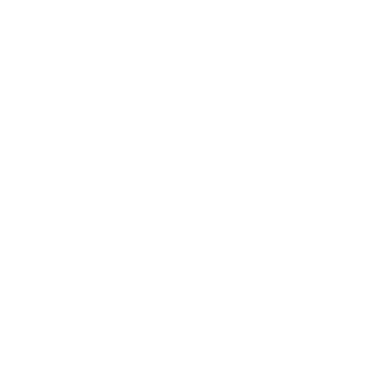

In [32]:
#遍历每一层图像和mask
fig = plt.figure()
camera = Camera(fig)

# 遍历每一层
for i in tqdm.tqdm(range(layer_num)):
    # 获取该层画面
    layer = normalized[:,:,i]
    
    # 处理输入
    input = torch.tensor([[layer]]).to('cuda:0',dtype=torch.float32)
    # 推理
    y_pred = model(input)
    
    # 获取对应的mask（筛选阈值0.5）
    mask_data = (y_pred.detach().cpu().numpy()[0][0] > 0.5)
    
    # 将mask和图片绘制在一起
    img_display = np.rot90(layer)
    mask_display = np.rot90(mask_data)   
    # 将mask_display像素值为0处遮挡起来
    mask = np.ma.masked_where(mask_display==0,mask_display)
    plt.imshow(img_display,cmap='bone')
    plt.imshow(mask,alpha=0.8,cmap='spring')
    # break
    plt.axis('off')
    
    camera.snap()
    
animation = camera.animate()

In [33]:
HTML(animation.to_html5_video())